In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteF5DIZ0/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteF5DIZ0/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [4]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

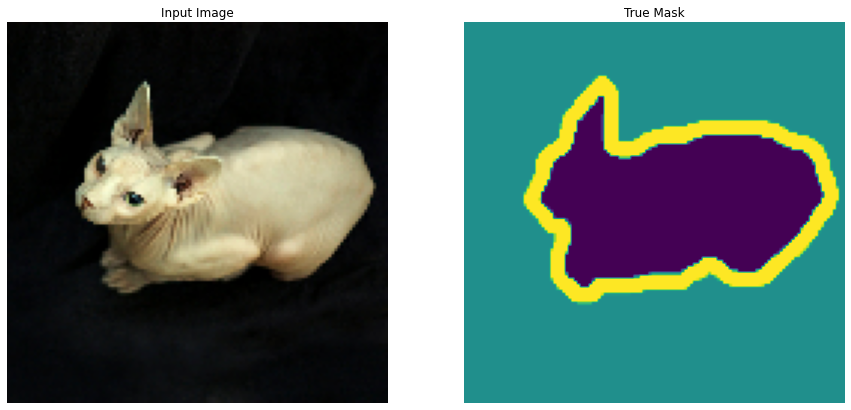

In [7]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [14]:
import os
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [15]:
def TL_unet_model(input_shape):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False, 
                   weights = "imagenet", 
                   input_shape = input_shape)

    # freezing all layers in VGG16 
    for layer in base_VGG.layers: 
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_VGG.get_layer("block5_conv3").output
    print(bridge.shape)

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model_


# Function for fine-tuning the model (unfreeze all layers) 
def finetune_unfreezeall(input_shape, base_model):
    input_shape = input_shape
    base_model = base_model
    
    # unfreeze the contracting path and freeze the expanding path
    for layer in base_model.layers:
        if layer.name in ['block1_conv1', 'block1_conv2', 'block1_pool',
                          'block2_conv1', 'block2_conv2', 'block2_pool', 
                          'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool',
                          'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',
                          'block5_conv1', 'block5_conv2', 'block5_conv3']:
            layer.trainable = True
            
    return base_model    


# [Failed] Approach 2: Adding Batch Normalization layer after each conv
def BN_pretrained(input_shape):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False, 
                   weights = "imagenet", 
                   input_shape = input_shape)

    # Building the encoder
    inp = base_VGG.input
    conv1 = base_VGG.get_layer(name='block1_conv1')(inp)
    conv1 = BatchNormalization()(conv1)
    conv1 = base_VGG.get_layer(name='block1_conv2')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = base_VGG.get_layer(name='block1_pool')(conv1)
    
    conv2 = base_VGG.get_layer(name='block2_conv1')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = base_VGG.get_layer(name='block2_conv2')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = base_VGG.get_layer(name='block2_pool')(conv2)
    
    conv3 = base_VGG.get_layer(name='block3_conv1')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = base_VGG.get_layer(name='block3_conv2')(conv3)
    conv3 = BatchNormalization()(conv3)
    comv3 = base_VGG.get_layer(name='block3_conv3')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = base_VGG.get_layer(name='block3_pool')(conv2)

    conv4 = base_VGG.get_layer(name='block4_conv1')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = base_VGG.get_layer(name='block4_conv2')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = base_VGG.get_layer(name='block4_conv3')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = base_VGG.get_layer(name='block4_pool')(conv4)
    
    conv5 = base_VGG.get_layer(name='block5_conv1')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = base_VGG.get_layer(name='block5_conv2')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = base_VGG.get_layer(name='block5_conv3')(conv5)
    conv5 = BatchNormalization()(conv5)

    # freezing all layers in VGG16 
    for layer in base_VGG.layers: 
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_VGG.get_layer("block5_conv3").output
    print(bridge.shape)
    
    
    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    print(up1.shape)
    up1 = BatchNormalization()(up1)
    
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    up2 = BatchNormalization()(up2)
    
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    up3 = BatchNormalization()(up3)
    
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    up4 = BatchNormalization()(up4)
    
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model_



# Model version 3 Cross domain pre-train with large XPIE dataset
# this is the U-Net model structure 
def unet_model_v3(input_shape):
    
    inp = Input(input_shape)
    
    # contracting path 
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Expanding path 
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    print(up1.shape)
    
    concat_1 = concatenate([up1, conv4], axis=3)
    
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    
    concat_2 = concatenate([up2, conv3], axis=3)
    
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    
    concat_3 = concatenate([up3, conv2], axis=3)
    
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    
    concat_4 = concatenate([up4, conv1], axis=3)
    
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    print(conv10.shape)

    model_ = Model(inputs=[inp], outputs=[conv10])
    
    return model_

In [16]:
model = TL_unet_model([128, 128, 3])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
(None, 8, 8, 512)
(None, 16, 16, 512)
(None, 32, 32, 256)
(None, 64, 64, 128)
(None, 128, 128, 64)
(None, 128, 128, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_c

In [26]:
def TL_unet_model2(input_shape):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False, 
                   weights = "imagenet", 
                   input_shape = input_shape)

    # freezing all layers in VGG16 
    # for layer in base_VGG.layers: 
    #     layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_VGG.get_layer("block5_conv3").output
    print(bridge.shape)

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model_

In [28]:
model = TL_unet_model2([128, 128, 3])
model.summary()

(None, 8, 8, 512)
(None, 16, 16, 512)
(None, 32, 32, 256)
(None, 64, 64, 128)
(None, 128, 128, 64)
(None, 128, 128, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 0s 241ms/step


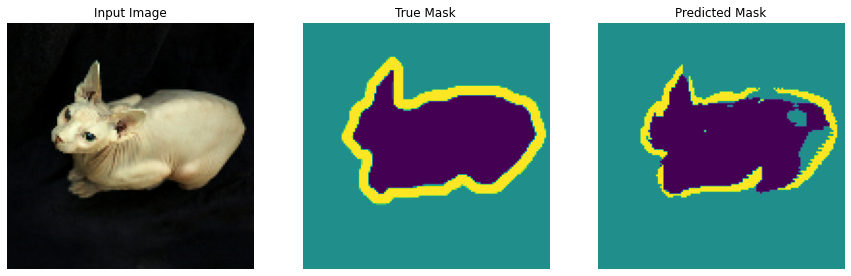


Sample Prediction after epoch 1

920/920 [==============================] - 84s 82ms/step - loss: 0.7096 - accuracy: 0.6833 - val_loss: 0.5512 - val_accuracy: 0.7736
Epoch 2/20
1/1 [==============================] - 0s 22ms/step


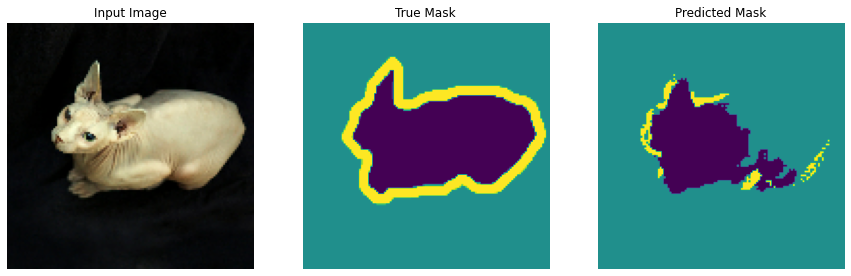


Sample Prediction after epoch 2

920/920 [==============================] - 74s 81ms/step - loss: 0.6335 - accuracy: 0.7355 - val_loss: 0.5978 - val_accuracy: 0.7507
Epoch 3/20
1/1 [==============================] - 0s 21ms/step


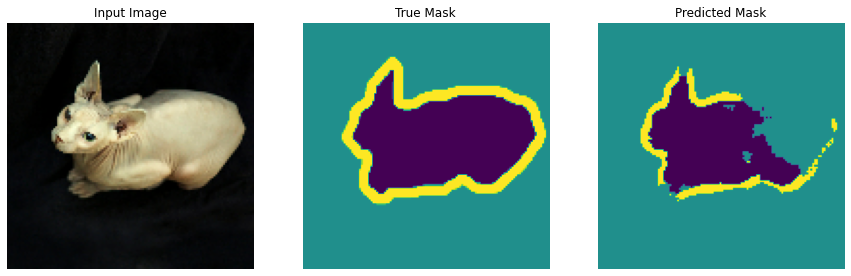


Sample Prediction after epoch 3

920/920 [==============================] - 75s 81ms/step - loss: 0.5271 - accuracy: 0.7819 - val_loss: 0.4889 - val_accuracy: 0.8003
Epoch 4/20
1/1 [==============================] - 0s 25ms/step


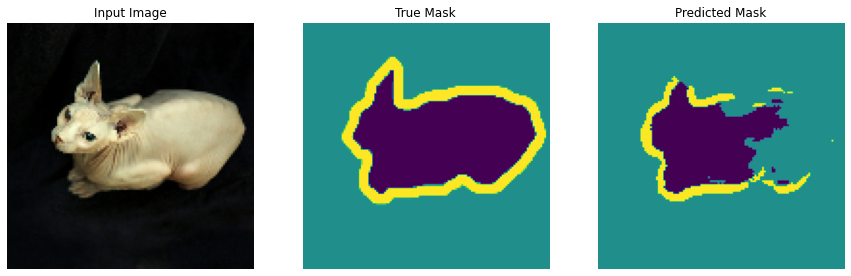


Sample Prediction after epoch 4

920/920 [==============================] - 75s 81ms/step - loss: 0.4680 - accuracy: 0.8083 - val_loss: 0.4641 - val_accuracy: 0.8097
Epoch 5/20
1/1 [==============================] - 0s 27ms/step


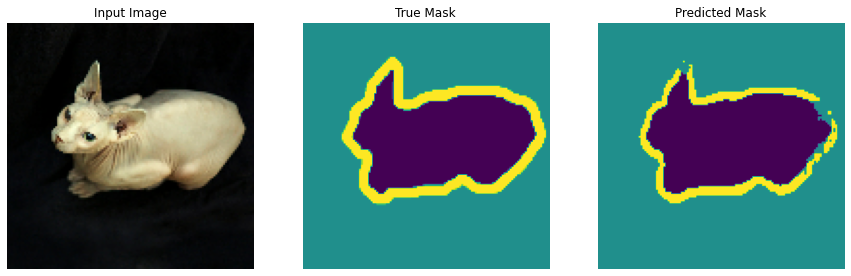


Sample Prediction after epoch 5

920/920 [==============================] - 75s 81ms/step - loss: 0.4271 - accuracy: 0.8259 - val_loss: 0.3980 - val_accuracy: 0.8387
Epoch 6/20
1/1 [==============================] - 0s 26ms/step


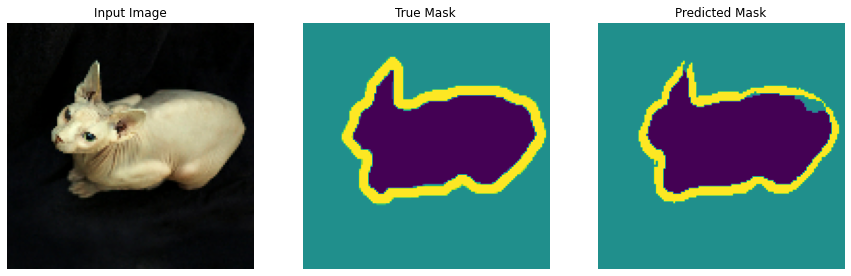


Sample Prediction after epoch 6

920/920 [==============================] - 75s 81ms/step - loss: 0.4012 - accuracy: 0.8367 - val_loss: 0.3961 - val_accuracy: 0.8392
Epoch 7/20
1/1 [==============================] - 0s 23ms/step


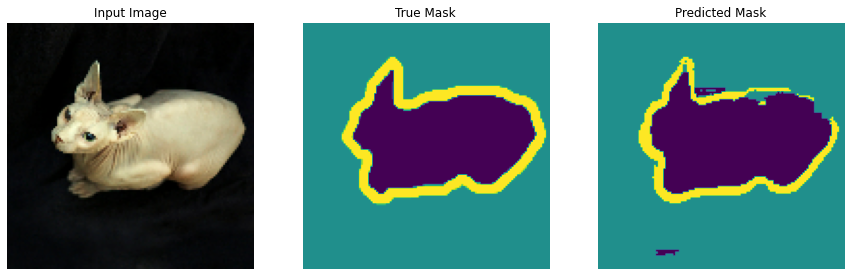


Sample Prediction after epoch 7

920/920 [==============================] - 75s 81ms/step - loss: 0.3832 - accuracy: 0.8441 - val_loss: 0.4101 - val_accuracy: 0.8392
Epoch 8/20
1/1 [==============================] - 0s 22ms/step


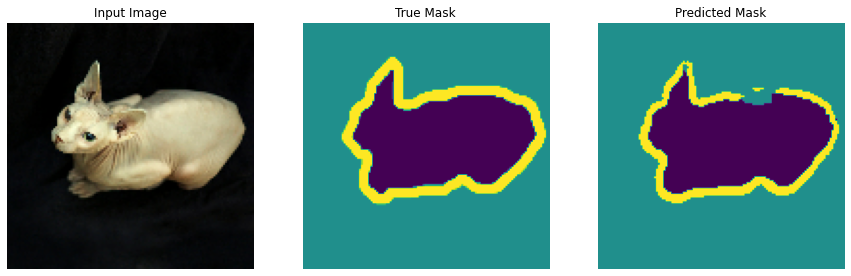


Sample Prediction after epoch 8

920/920 [==============================] - 75s 81ms/step - loss: 0.3760 - accuracy: 0.8473 - val_loss: 0.3680 - val_accuracy: 0.8530
Epoch 9/20
1/1 [==============================] - 0s 27ms/step


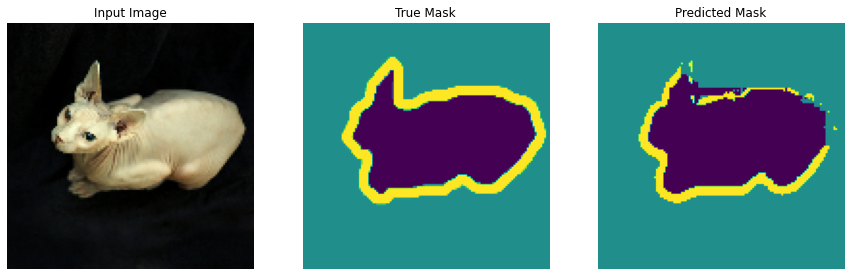


Sample Prediction after epoch 9

920/920 [==============================] - 76s 82ms/step - loss: 0.3543 - accuracy: 0.8552 - val_loss: 0.3624 - val_accuracy: 0.8520
Epoch 10/20
1/1 [==============================] - 0s 35ms/step


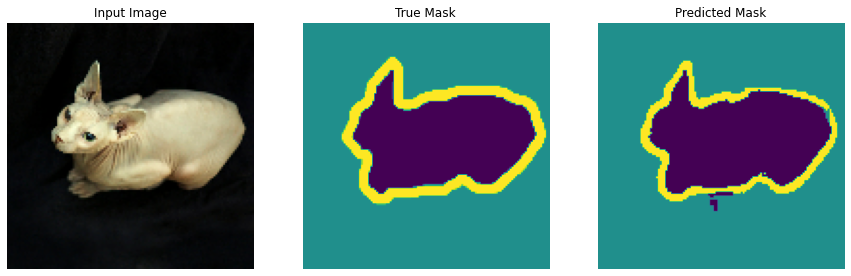


Sample Prediction after epoch 10

920/920 [==============================] - 76s 82ms/step - loss: 0.3513 - accuracy: 0.8573 - val_loss: 0.3619 - val_accuracy: 0.8514
Epoch 11/20
1/1 [==============================] - 0s 23ms/step


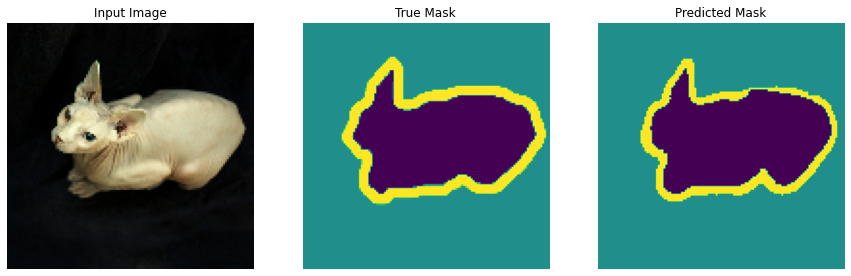


Sample Prediction after epoch 11

920/920 [==============================] - 76s 82ms/step - loss: 0.3333 - accuracy: 0.8641 - val_loss: 0.3531 - val_accuracy: 0.8588
Epoch 12/20
1/1 [==============================] - 0s 22ms/step


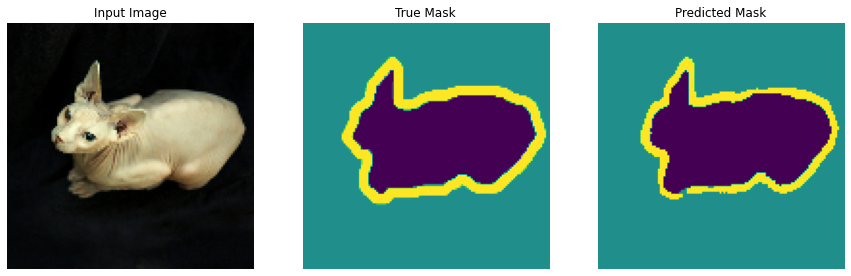


Sample Prediction after epoch 12

920/920 [==============================] - 75s 82ms/step - loss: 0.3182 - accuracy: 0.8698 - val_loss: 0.3499 - val_accuracy: 0.8616
Epoch 13/20
1/1 [==============================] - 0s 26ms/step


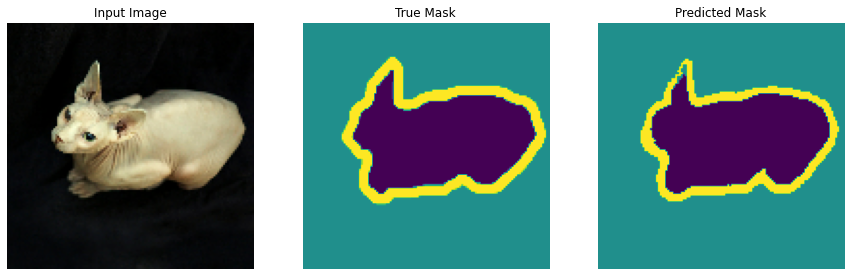


Sample Prediction after epoch 13

920/920 [==============================] - 75s 82ms/step - loss: 0.3089 - accuracy: 0.8738 - val_loss: 0.3534 - val_accuracy: 0.8588
Epoch 14/20
1/1 [==============================] - 0s 22ms/step


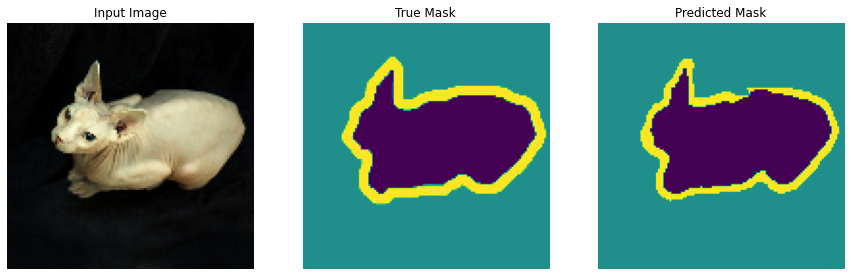


Sample Prediction after epoch 14

920/920 [==============================] - 75s 81ms/step - loss: 0.2982 - accuracy: 0.8778 - val_loss: 0.3489 - val_accuracy: 0.8571
Epoch 15/20
1/1 [==============================] - 0s 24ms/step


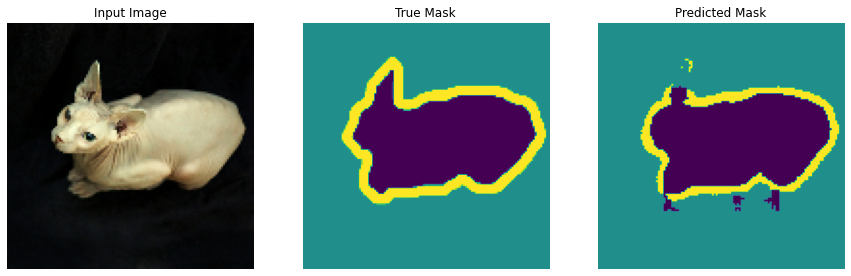


Sample Prediction after epoch 15

920/920 [==============================] - 75s 82ms/step - loss: 0.2874 - accuracy: 0.8821 - val_loss: 0.3755 - val_accuracy: 0.8527
Epoch 16/20
1/1 [==============================] - 0s 22ms/step


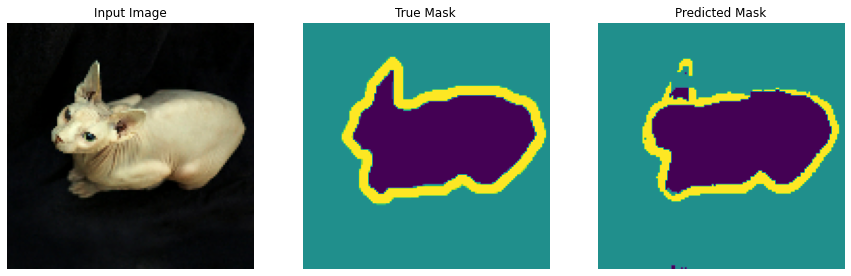


Sample Prediction after epoch 16

920/920 [==============================] - 75s 82ms/step - loss: 0.2755 - accuracy: 0.8861 - val_loss: 0.3751 - val_accuracy: 0.8526
Epoch 17/20
1/1 [==============================] - 0s 22ms/step


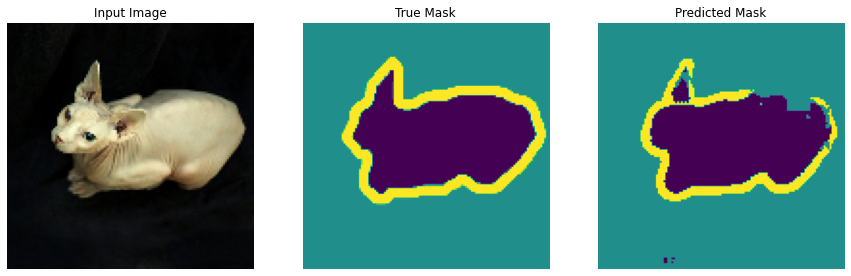


Sample Prediction after epoch 17

920/920 [==============================] - 75s 82ms/step - loss: 0.2625 - accuracy: 0.8912 - val_loss: 0.3416 - val_accuracy: 0.8623
Epoch 18/20
1/1 [==============================] - 0s 25ms/step


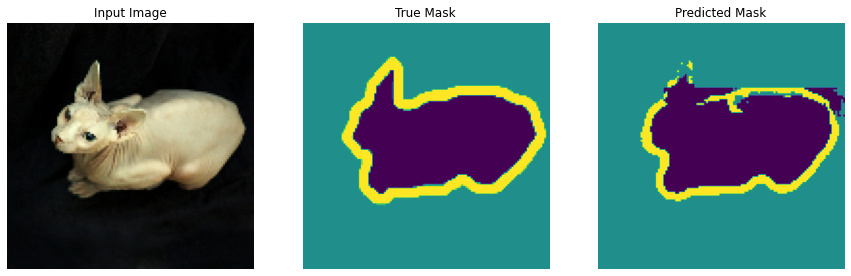


Sample Prediction after epoch 18

920/920 [==============================] - 75s 82ms/step - loss: 0.2525 - accuracy: 0.8950 - val_loss: 0.3756 - val_accuracy: 0.8514
Epoch 19/20
1/1 [==============================] - 0s 25ms/step


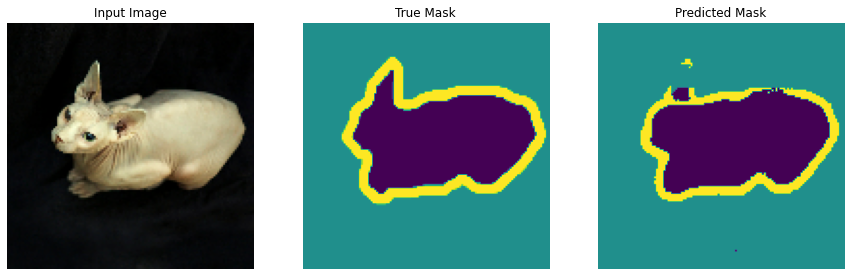


Sample Prediction after epoch 19

920/920 [==============================] - 75s 82ms/step - loss: 0.2464 - accuracy: 0.8976 - val_loss: 0.3762 - val_accuracy: 0.8627
Epoch 20/20
1/1 [==============================] - 0s 27ms/step


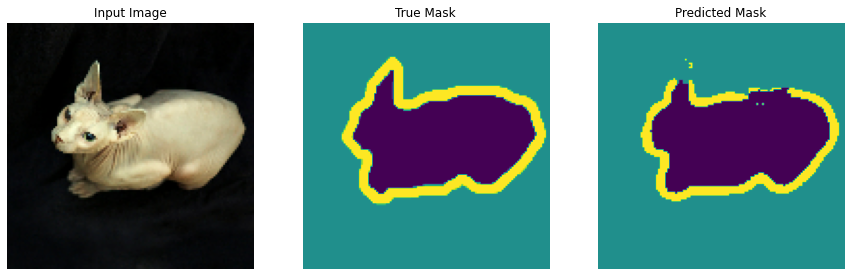


Sample Prediction after epoch 20

920/920 [==============================] - 75s 82ms/step - loss: 0.2348 - accuracy: 0.9016 - val_loss: 0.3615 - val_accuracy: 0.8631


In [33]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

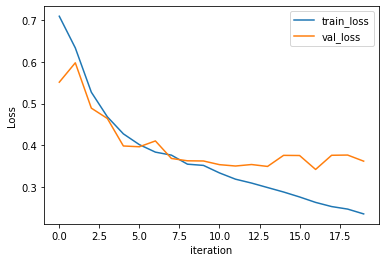

In [34]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['loss'], label = "train_loss")
plt.plot(model_history.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()




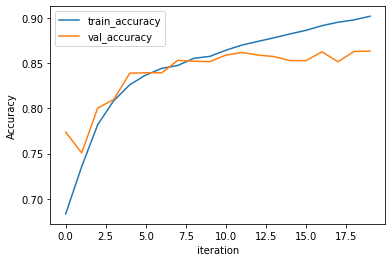

In [35]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'], label = "train_accuracy")
plt.plot(model_history.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

1/1 [==============================] - 0s 51ms/step


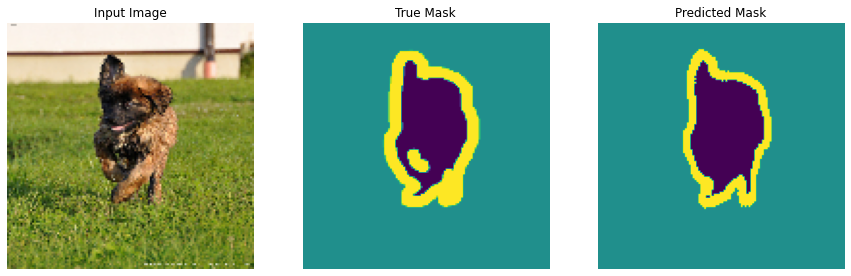

1/1 [==============================] - 0s 37ms/step


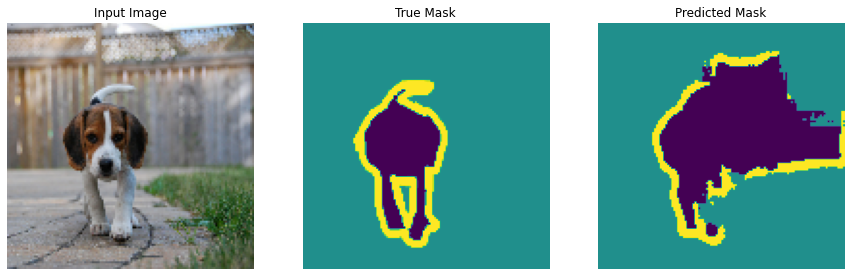

1/1 [==============================] - 0s 37ms/step


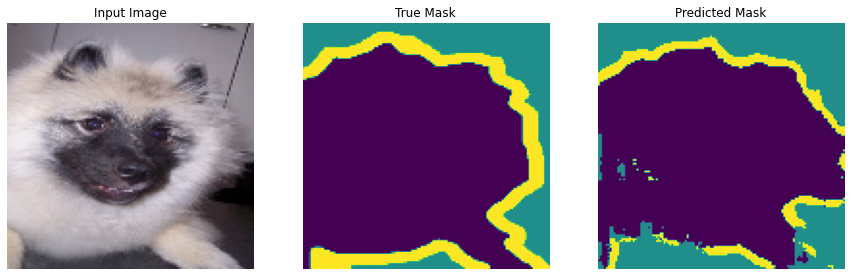

1/1 [==============================] - 0s 38ms/step


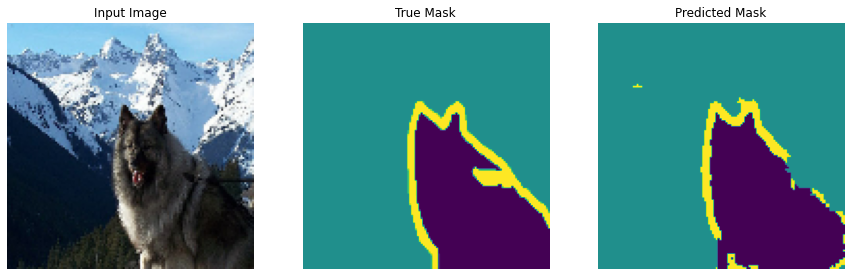

1/1 [==============================] - 0s 50ms/step


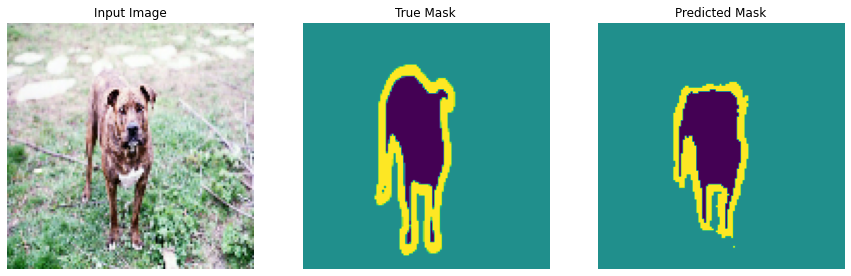

1/1 [==============================] - 0s 28ms/step


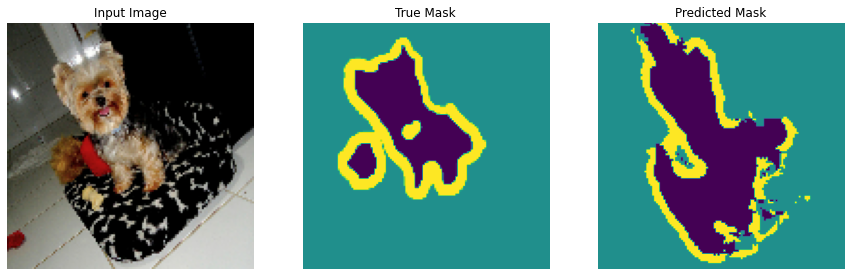

1/1 [==============================] - 0s 24ms/step


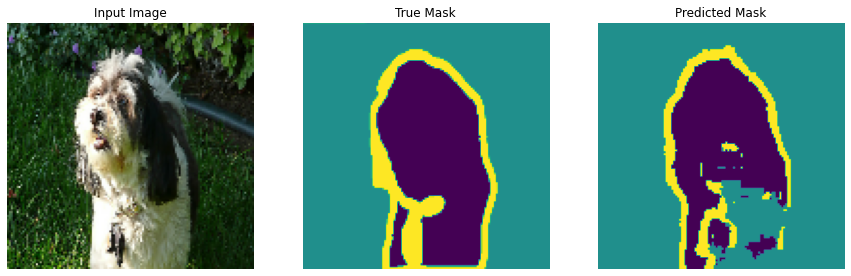

1/1 [==============================] - 0s 22ms/step


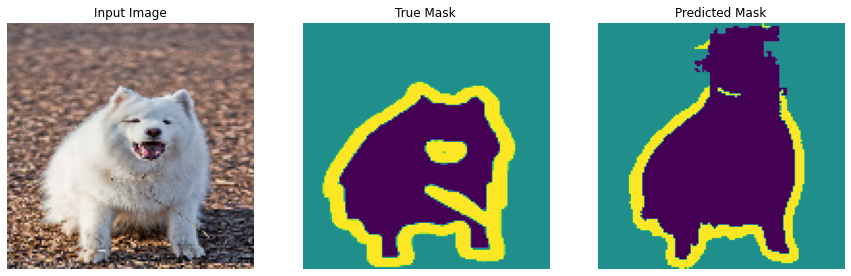

1/1 [==============================] - 0s 22ms/step


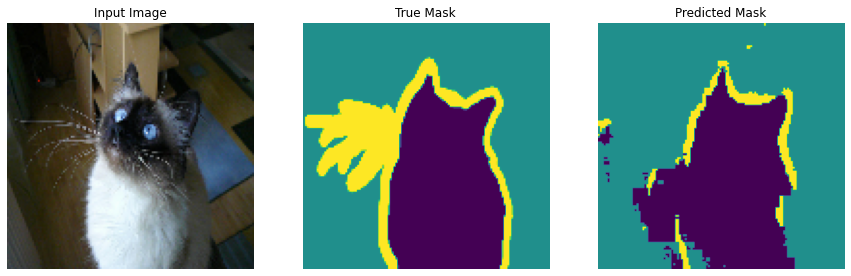

1/1 [==============================] - 0s 28ms/step


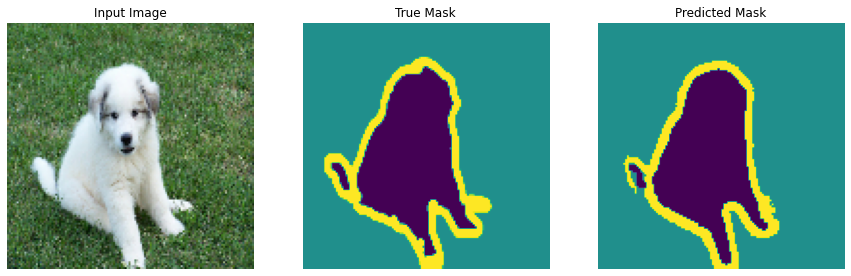

1/1 [==============================] - 0s 41ms/step


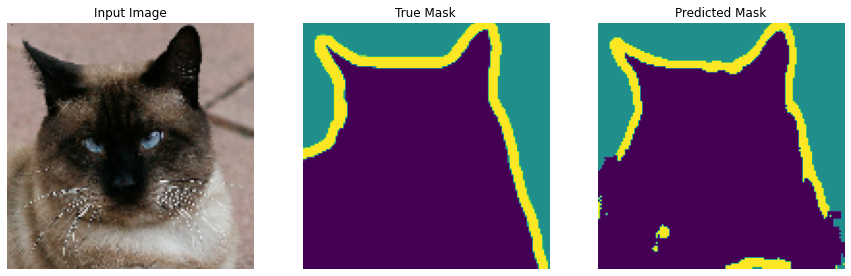

1/1 [==============================] - 0s 28ms/step


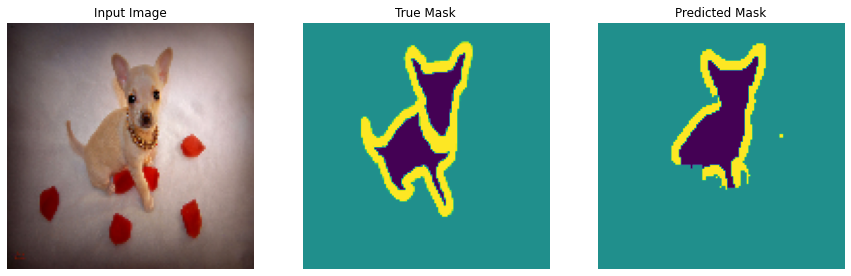

1/1 [==============================] - 0s 29ms/step


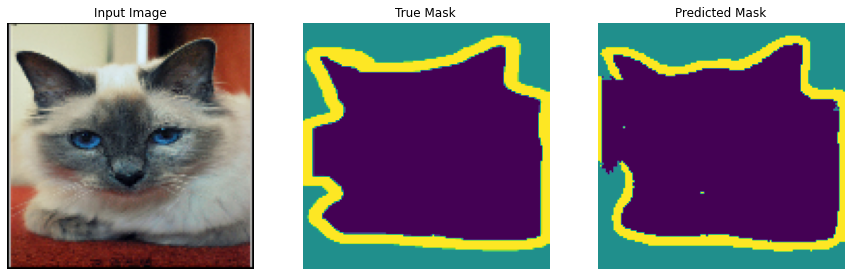

1/1 [==============================] - 0s 32ms/step


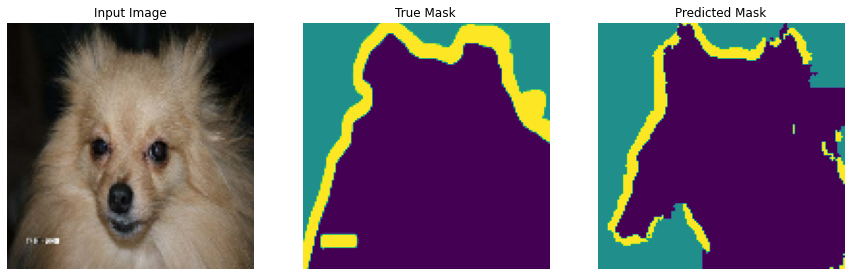

1/1 [==============================] - 0s 27ms/step


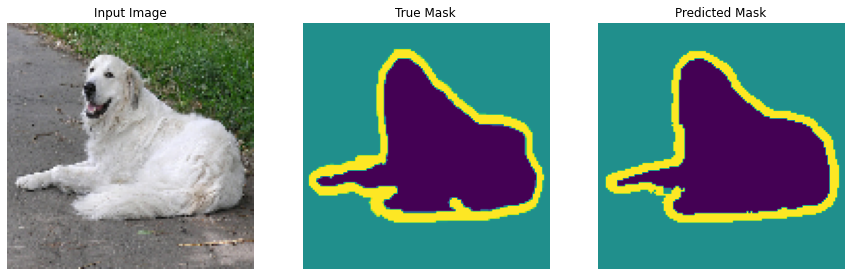

In [36]:
show_predictions(test_dataset, 15)